In [1]:
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [4]:
train_data = pd.read_csv('/Users/marlenawasiak/Desktop/Data_Collection/UNSW_NB15_training-set.csv')
test_data = pd.read_csv('/Users/marlenawasiak/Desktop/Data_Collection/UNSW_NB15_testing-set.csv')

In [6]:
X_train = train_data.drop(columns=['attack_cat'])
y_train = train_data['attack_cat']

X_test = test_data.drop(columns=['attack_cat'])
y_test = test_data['attack_cat']

# Encode categorical features
categorical_features = ['proto', 'service', 'state']
X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

# Align test set columns with training set columns (fill missing columns with 0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Encode the target label (attack category) in both training and test sets
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Apply oversampling to the training set
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Scale the training and test sets
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)  # Fit and transform on training set
X_test_scaled = scaler.transform(X_test)                     # Only transform the test set


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define the neural network model
# Experiment with a deeper model
model = Sequential()
model.add(Dense(128, input_dim=X_train_resampled.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), class_weight=class_weight_dict)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 13s 732us/step - accuracy: 0.6494 - loss: 0.8811 - val_accuracy: 0.6870 - val_loss: 1.1151
Epoch 2/50
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 11s 653us/step - accuracy: 0.7234 - loss: 0.6700 - val_accuracy: 0.6623 - val_loss: 1.6106
Epoch 3/50
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 11s 630us/step - accuracy: 0.7311 - loss: 0.6407 - val_accuracy: 0.8182 - val_loss: 1.1550
Epoch 4/50
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 12s 664us/step - accuracy: 0.7368 - loss: 0.6235 - val_accuracy: 0.6679 - val_loss: 2.6122
Epoch 5/50
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 11s 655us/step - accuracy: 0.7425 - loss: 0.6070 - val_accuracy: 0.6647 - val_loss: 2.8054
Epoch 6/50
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 12s 683us/step - accuracy: 0.7444 - loss: 0.6010 - val_accuracy: 0.7510 - val_loss: 2.1892
Epoch 7/50
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 13s 717us/step - accuracy: 0.7481 - loss: 0.5912 - val_accuracy: 0.6681 - val_loss: 3.7713
Epoch 8/50
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 12s 675us/s

In [45]:
# Evaluate the model
y_pred_encoded = model.predict(X_test_scaled).argmax(axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred_encoded)
print("Test Accuracy:", test_accuracy)

# Generate classification report with specified labels to handle all classes
class_report = classification_report(
    y_test, 
    y_pred_encoded, 
    labels=range(len(label_encoder.classes_)), 
    target_names=label_encoder.classes_, 
    zero_division=1
)
print("Classification Report:\n", class_report)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step
Test Accuracy: 0.8189768255356362
Classification Report:
                 precision    recall  f1-score   support

      Analysis       0.03      0.06      0.04       677
      Backdoor       0.03      0.25      0.06       583
           DoS       0.26      0.33      0.29      4089
      Exploits       0.74      0.48      0.58     11132
       Fuzzers       0.70      0.65      0.67      6062
       Generic       0.95      0.92      0.94     18871
        Normal       1.00      1.00      1.00     37000
Reconnaissance       0.77      0.59      0.67      3496
     Shellcode       0.21      0.42      0.28       378
         Worms       0.14      0.20      0.17        44

      accuracy                           0.82     82332
     macro avg       0.48      0.49      0.47     82332
  weighted avg       0.87      0.82      0.84     82332



In [51]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
import tensorflow as tf

/opt/anaconda3/lib/python3.11/site-packages/art/estimators/certification/__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [55]:
# Wrap the Keras model in an ART classifier
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=len(label_encoder.classes_),
    input_shape=(X_train_resampled.shape[1],),
    loss_object=tf.keras.losses.SparseCategoricalCrossentropy()
)


In [59]:
# Set up FGSM attack
epsilon = 0.1
attack = FastGradientMethod(estimator=classifier, eps=epsilon)

# Generate adversarial examples for the test set
X_test_adversarial_fgsm = attack.generate(x=X_test_scaled)


In [65]:
# Predict on adversarial examples
y_pred_adversarial = model.predict(X_test_adversarial_fgsm).argmax(axis=1)

# Calculate accuracy on adversarial examples
adversarial_accuracy = accuracy_score(y_test, y_pred_adversarial)
print("Adversarial Accuracy:", adversarial_accuracy)

# Generate classification report on adversarial examples
adversarial_class_report = classification_report(
    y_test, 
    y_pred_adversarial, 
    labels=range(len(label_encoder.classes_)), 
    target_names=label_encoder.classes_, 
    zero_division=1
)
print("Classification Report on Adversarial Examples:\n", adversarial_class_report)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 259us/step
Adversarial Accuracy: 0.5771024631977846
Classification Report on Adversarial Examples:
                 precision    recall  f1-score   support

      Analysis       0.01      0.01      0.01       677
      Backdoor       0.01      0.06      0.02       583
           DoS       0.18      0.50      0.26      4089
      Exploits       0.21      0.29      0.24     11132
       Fuzzers       0.12      0.16      0.14      6062
       Generic       0.91      0.21      0.34     18871
        Normal       1.00      1.00      1.00     37000
Reconnaissance       0.23      0.07      0.11      3496
     Shellcode       0.01      0.01      0.01       378
         Worms       0.01      0.02      0.02        44

      accuracy                           0.58     82332
     macro avg       0.27      0.23      0.21     82332
  weighted avg       0.71      0.58      0.59     82332



In [68]:
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import TensorFlowV2Classifier
import tensorflow as tf

In [73]:
# Wrap the Keras model in an ART classifier
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=len(label_encoder.classes_),
    input_shape=(X_train_resampled.shape[1],),
    loss_object=tf.keras.losses.SparseCategoricalCrossentropy()
)

In [76]:
# Set up the PGD attack
epsilon = 0.1         # Maximum perturbation
eps_step = 0.01       # Step size per iteration
max_iter = 40         # Number of attack iterations

attack = ProjectedGradientDescent(
    estimator=classifier, 
    eps=epsilon, 
    eps_step=eps_step, 
    max_iter=max_iter
)

# Generate adversarial examples
X_test_adversarial = attack.generate(x=X_test_scaled)

PGD - Batches: 0it [00:00, ?it/s]

2024-11-04 19:22:29.946959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [86]:
# Predict on adversarial examples
y_pred_adversarial = model.predict(X_test_adversarial).argmax(axis=1)

# Calculate accuracy on adversarial examples
adversarial_accuracy = accuracy_score(y_test, y_pred_adversarial)
print("Adversarial Accuracy:", adversarial_accuracy)

# Generate a classification report for adversarial examples
adversarial_class_report = classification_report(
    y_test, 
    y_pred_adversarial, 
    labels=range(len(label_encoder.classes_)), 
    target_names=label_encoder.classes_, 
    zero_division=1
)
print("Classification Report on Adversarial Examples:\n", adversarial_class_report)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 244us/step
Adversarial Accuracy: 0.5417820531506583
Classification Report on Adversarial Examples:
                 precision    recall  f1-score   support

      Analysis       0.02      0.07      0.03       677
      Backdoor       0.02      0.11      0.04       583
           DoS       0.18      0.43      0.26      4089
      Exploits       0.12      0.13      0.12     11132
       Fuzzers       0.09      0.16      0.12      6062
       Generic       0.88      0.15      0.25     18871
        Normal       1.00      1.00      1.00     37000
Reconnaissance       0.32      0.14      0.20      3496
     Shellcode       0.02      0.13      0.03       378
         Worms       0.01      0.09      0.02        44

      accuracy                           0.54     82332
     macro avg       0.27      0.24      0.21     82332
  weighted avg       0.70      0.54      0.55     82332



In [92]:
from sklearn.model_selection import train_test_split
import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

# Select a random sample (e.g., 10%) of the test data
sample_size = int(0.1 * len(X_test_scaled))
indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)

# Create the smaller subset
X_test_small = X_test_scaled[indices]
y_test_small = y_test[indices]


In [97]:
# Wrap the Keras model in an ART classifier
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=len(label_encoder.classes_),
    input_shape=(X_train_resampled.shape[1],),
    loss_object=tf.keras.losses.SparseCategoricalCrossentropy()
)


In [100]:
from art.attacks.evasion import CarliniL2Method

# Configure the C&W attack
attack = CarliniL2Method(classifier=classifier, confidence=0.1, max_iter=10, batch_size=32)

# Generate adversarial examples on the smaller subset
X_test_cw = attack.generate(x=X_test_small)

C&W L_2:   0%|          | 0/258 [00:00<?, ?it/s]

In [107]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on adversarial examples
y_pred_cw = model.predict(X_test_cw).argmax(axis=1)

# Calculate accuracy on adversarial examples
cw_accuracy = accuracy_score(y_test_small, y_pred_cw)
print("Carlini & Wagner Adversarial Accuracy:", cw_accuracy)

# Generate classification report on adversarial examples
cw_class_report = classification_report(
    y_test_small, 
    y_pred_cw, 
    labels=range(len(label_encoder.classes_)), 
    target_names=label_encoder.classes_, 
    zero_division=1
)
print("Classification Report on Carlini & Wagner Adversarial Examples:\n", cw_class_report)

# Optional: Confusion Matrix
cw_conf_matrix = confusion_matrix(y_test_small, y_pred_cw)
print("Confusion Matrix on Carlini & Wagner Adversarial Examples:\n", cw_conf_matrix)


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
Carlini & Wagner Adversarial Accuracy: 0.7124984817199077
Classification Report on Carlini & Wagner Adversarial Examples:
                 precision    recall  f1-score   support

      Analysis       0.04      0.11      0.06        65
      Backdoor       0.02      0.17      0.04        59
           DoS       0.20      0.43      0.28       398
      Exploits       0.32      0.22      0.26      1146
       Fuzzers       0.39      0.31      0.35       593
       Generic       0.96      0.78      0.86      1907
        Normal       1.00      1.00      1.00      3676
Reconnaissance       0.38      0.20      0.26       347
     Shellcode       0.05      0.19      0.08        37
         Worms       0.12      0.20      0.15         5

      accuracy                           0.71      8233
     macro avg       0.35      0.36      0.33      8233
  weighted avg       0.77      0.71      0.73      8233

Confusion Matrix on Carlini & Wagner Adversaria

In [117]:
import shap
import numpy as np

# Select a subset of the training data for SHAP (to save on computation time)
background_data = X_train_resampled[np.random.choice(X_train_resampled.shape[0], 100, replace=False)]

# Create the SHAP explainer
explainer = shap.DeepExplainer(model, background_data)


/opt/anaconda3/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [120]:
shap_values_clean = explainer.shap_values(X_test_scaled) 
print("Shape of shap_values_clean:", shap_values_clean.shape)
print("Shape of X_test_small:", X_test_small.shape)


Shape of shap_values_clean: (82332, 193, 10)
Shape of X_test_small: (8233, 193)


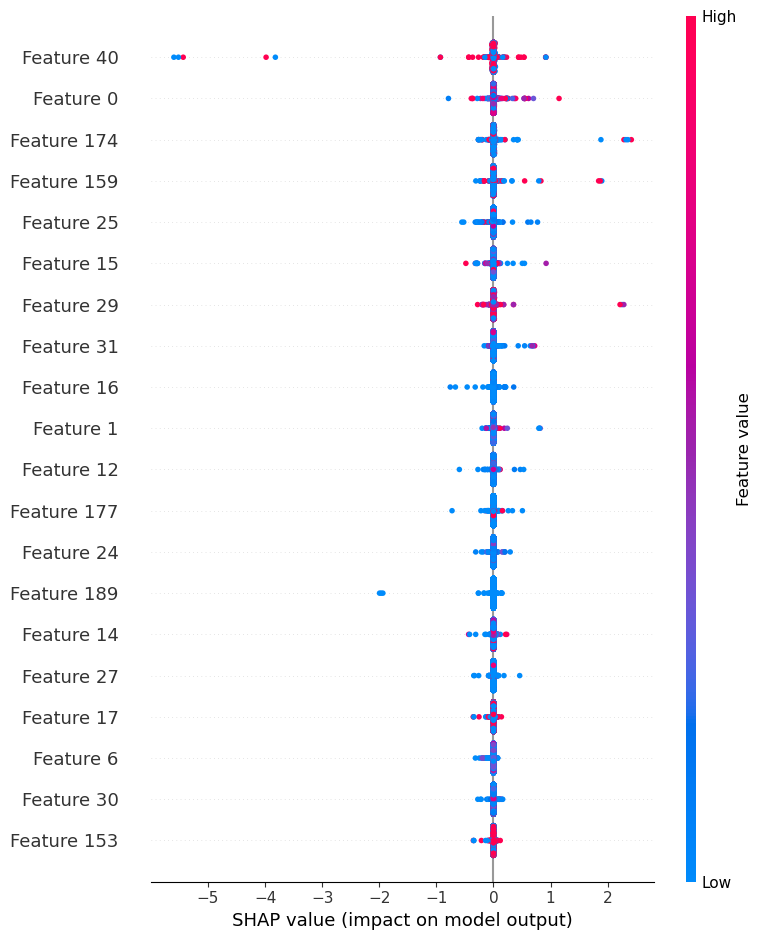

In [129]:
# Take a subset to ensure the number of instances matches
sample_size = min(shap_values_clean.shape[0], X_test_small.shape[0])  # Adjust sample size to the smaller dimension
shap_values_mean_sample = shap_values_clean[:sample_size].mean(axis=2)
X_test_small_sample = X_test_small[:sample_size]

# Generate SHAP summary plot
shap.summary_plot(shap_values_mean_sample, X_test_small_sample, plot_type="dot", title="SHAP Beeswarm Plot - Mean across Classes (Sampled Data)")


In [132]:
shap_values_fgsm = explainer.shap_values(X_test_adversarial_fgsm) 
print("Shape of shap_values_fgsm:", np.array(shap_values_fgsm).shape)
print("Shape of X_test_adversarial_fgsm:", X_test_adversarial_fgsm.shape)

Shape of shap_values_fgsm: (82332, 193, 10)
Shape of X_test_adversarial_fgsm: (82332, 193)


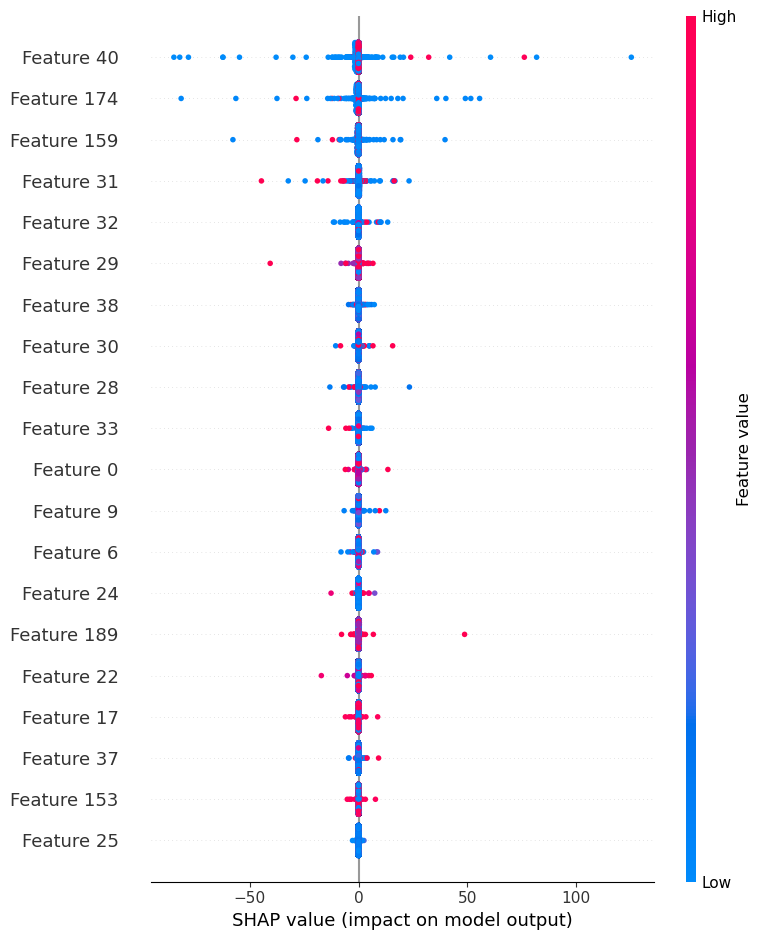

In [141]:
shap_values_fgsm_mean = shap_values_fgsm.mean(axis=2)
shap.summary_plot(shap_values_fgsm_mean, X_test_adversarial_fgsm, plot_type="dot", title="SHAP Summary for FGSM Adversarial Data - Mean across Classes")


In [143]:
shap_values_pgd = explainer.shap_values(X_test_adversarial) 
print("Shape of shap_values_fgsm:", np.array(shap_values_pgd).shape)
print("Shape of X_test_adversarial_fgsm:", X_test_adversarial.shape)


Shape of shap_values_fgsm: (82332, 193, 10)
Shape of X_test_adversarial_fgsm: (82332, 193)


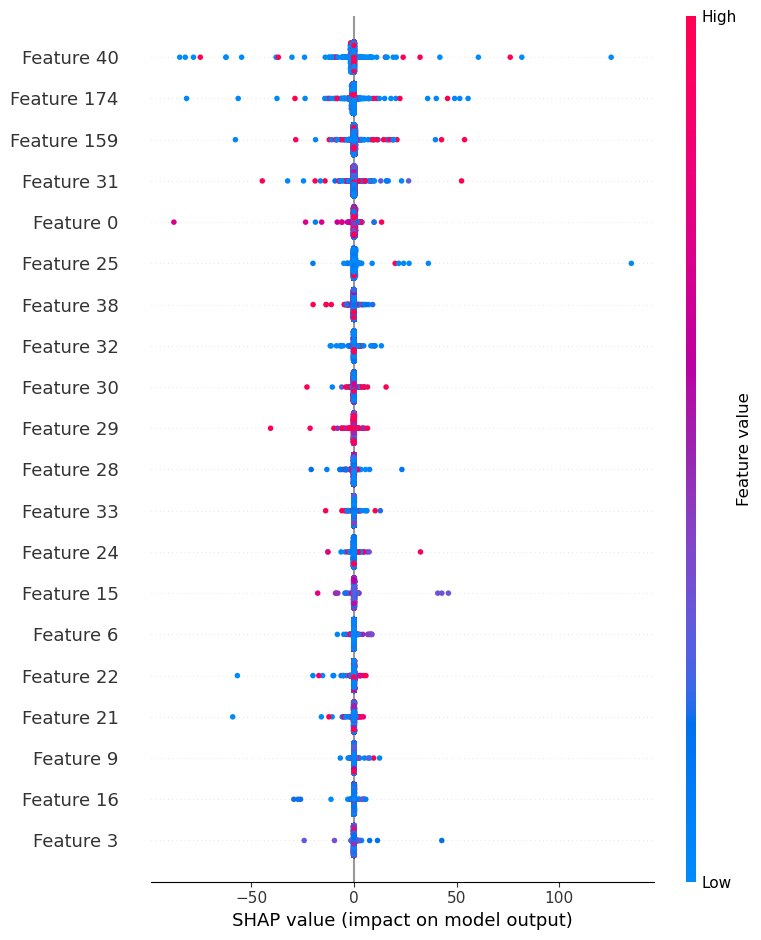

In [155]:
shap_values_pgd_mean = shap_values_pgd.mean(axis=2)
shap.summary_plot(shap_values_pgd_mean, X_test_adversarial, plot_type="dot", title="SHAP Summary for PGD Adversarial Data - Mean across Classes")


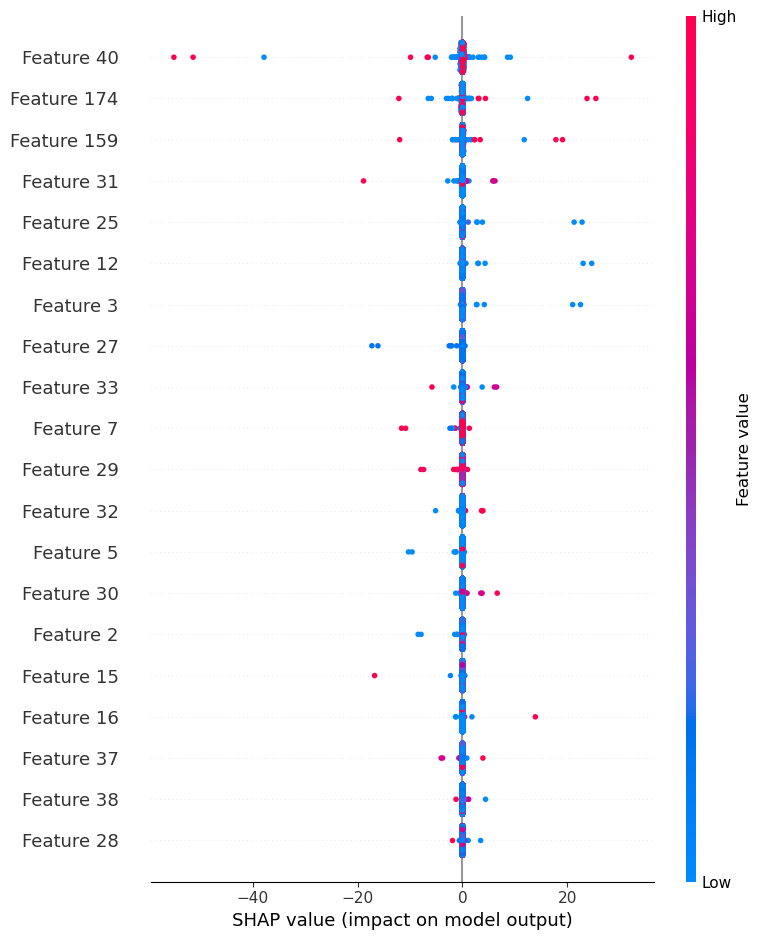

In [157]:
shap_values_cw = explainer.shap_values(X_test_cw)  
shap_values_cw_mean = shap_values_cw.mean(axis=2)
shap.summary_plot(shap_values_cw_mean, X_test_cw, plot_type="dot", title="SHAP Summary for Carlini & Wagner Adversarial Data")


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
# Assuming train_data and test_data are available
X_train = train_data.drop(columns=['attack_cat'])
y_train = train_data['attack_cat']
X_test = test_data.drop(columns=['attack_cat'])
y_test = test_data['attack_cat']

# Step 1: One-hot encode categorical features
categorical_features = ['proto', 'service', 'state']
X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Step 2: Encode the target labels (attack category)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Step 3: Handle class imbalance with oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train_encoded)

# Step 4: Scale features using StandardScaler and QuantileTransformer
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
X_train_scaled = quantile_transformer.fit_transform(X_train_scaled)
X_test_scaled = quantile_transformer.transform(X_test_scaled)

# Step 5: Define and compile the MLP model
num_classes = len(np.unique(y_train_encoded))
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # Ensure the output layer matches the number of classes
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = mlp_model.fit(X_train_scaled, y_train_resampled, epochs=30, batch_size=32, validation_data=(X_test_scaled, y_test_encoded))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 13s 724us/step - accuracy: 0.6310 - loss: 0.9339 - val_accuracy: 0.8338 - val_loss: 0.4327
Epoch 2/30
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 14s 775us/step - accuracy: 0.7042 - loss: 0.7234 - val_accuracy: 0.8326 - val_loss: 0.4690
Epoch 3/30
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 15s 853us/step - accuracy: 0.7146 - loss: 0.6975 - val_accuracy: 0.8254 - val_loss: 0.5084
Epoch 4/30
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 13s 751us/step - accuracy: 0.7226 - loss: 0.6779 - val_accuracy: 0.8360 - val_loss: 0.6104
Epoch 5/30
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 14s 783us/step - accuracy: 0.7255 - loss: 0.6660 - val_accuracy: 0.6613 - val_loss: 1.1177
Epoch 6/30
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 13s 748us/step - accuracy: 0.7277 - loss: 0.6587 - val_accuracy: 0.8254 - val_loss: 0.7379
Epoch 7/30
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 13s 754us/step - accuracy: 0.7308 - loss: 0.6509 - val_accuracy: 0.8259 - val_loss: 0.8374
Epoch 8/30
17500/17500 ━━━━━━━━━━━━━━━━━━━━ 13s 726us/s

In [49]:
# Step 7: Evaluate the model on clean data
y_pred = mlp_model.predict(X_test_scaled).argmax(axis=1)
clean_accuracy = accuracy_score(y_test_encoded, y_pred)

# Step 8: Decode predictions for a report with original class labels
y_test_labels = label_encoder.inverse_transform(y_test_encoded)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Classification report and confusion matrix with decoded labels
decoded_class_report = classification_report(y_test_labels, y_pred_labels, zero_division=1)
decoded_conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

# Print the results
print("MLP Model Accuracy on Clean Data:", clean_accuracy)
print("\nClassification Report on Clean Data with Attack Names:\n", decoded_class_report)
print("\nConfusion Matrix on Clean Data with Attack Names:\n", decoded_conf_matrix)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 367us/step
MLP Model Accuracy on Clean Data: 0.8334547927901667

Classification Report on Clean Data with Attack Names:
                 precision    recall  f1-score   support

      Analysis       0.13      0.46      0.20       677
      Backdoor       0.04      0.36      0.07       583
           DoS       0.38      0.08      0.14      4089
      Exploits       0.82      0.53      0.64     11132
       Fuzzers       0.77      0.59      0.67      6062
       Generic       1.00      0.96      0.98     18871
        Normal       1.00      1.00      1.00     37000
Reconnaissance       0.85      0.81      0.83      3496
     Shellcode       0.15      0.88      0.25       378
         Worms       0.05      0.68      0.09        44

      accuracy                           0.83     82332
     macro avg       0.52      0.64      0.49     82332
  weighted avg       0.90      0.83      0.86     82332


Confusion Matrix on Clean Data with Attack Names:
 [[  31

In [51]:
from art.estimators.classification import TensorFlowV2Classifier
import tensorflow as tf

# Wrap the MLP model in an ART classifier
classifier = TensorFlowV2Classifier(
    model=mlp_model,
    nb_classes=len(label_encoder.classes_),  # Total number of classes
    input_shape=(X_train_scaled.shape[1],),  # Shape of input features
    loss_object=tf.keras.losses.SparseCategoricalCrossentropy()
)


In [53]:
from art.attacks.evasion import FastGradientMethod

# Configure the FGSM attack
epsilon = 0.1  # You can experiment with different values
fgsm_attack = FastGradientMethod(estimator=classifier, eps=epsilon)

# Generate adversarial examples on the test set
X_test_fgsm = fgsm_attack.generate(x=X_test_scaled)


In [54]:
# Predict on the FGSM adversarial examples
y_pred_fgsm = mlp_model.predict(X_test_fgsm).argmax(axis=1)

# Decode the predicted labels for interpretability
y_pred_fgsm_labels = label_encoder.inverse_transform(y_pred_fgsm)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Calculate accuracy and generate the classification report
fgsm_accuracy = accuracy_score(y_test_labels, y_pred_fgsm_labels)
fgsm_class_report = classification_report(y_test_labels, y_pred_fgsm_labels, zero_division=1)
fgsm_conf_matrix = confusion_matrix(y_test_labels, y_pred_fgsm_labels)

print("MLP Model Accuracy on FGSM Adversarial Examples:", fgsm_accuracy)
print("\nClassification Report on FGSM Adversarial Examples:\n", fgsm_class_report)
print("\nConfusion Matrix on FGSM Adversarial Examples:\n", fgsm_conf_matrix)

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 320us/step
MLP Model Accuracy on FGSM Adversarial Examples: 0.7309794490599038

Classification Report on FGSM Adversarial Examples:
                 precision    recall  f1-score   support

      Analysis       0.10      0.44      0.16       677
      Backdoor       0.03      0.16      0.05       583
           DoS       0.07      0.12      0.09      4089
      Exploits       0.78      0.50      0.61     11132
       Fuzzers       0.58      0.52      0.55      6062
       Generic       1.00      0.69      0.81     18871
        Normal       1.00      1.00      1.00     37000
Reconnaissance       0.36      0.09      0.14      3496
     Shellcode       0.07      0.78      0.12       378
         Worms       0.03      0.39      0.05        44

      accuracy                           0.73     82332
     macro avg       0.40      0.47      0.36     82332
  weighted avg       0.85      0.73      0.77     82332


Confusion Matrix on FGSM Adversarial Examples

In [60]:
from art.attacks.evasion import ProjectedGradientDescent

# Configure PGD attack parameters
epsilon = 0.1         # Maximum perturbation
eps_step = 0.01       # Step size per iteration
max_iter = 40         # Number of iterations

# Create the PGD attack
pgd_attack = ProjectedGradientDescent(
    estimator=classifier, 
    eps=epsilon, 
    eps_step=eps_step, 
    max_iter=max_iter
)

# Generate adversarial examples on the test set
X_test_pgd = pgd_attack.generate(x=X_test_scaled)

PGD - Batches: 0it [00:00, ?it/s]

2024-11-06 19:17:52.610896: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [67]:
# Predict on the PGD adversarial examples
y_pred_pgd = mlp_model.predict(X_test_pgd).argmax(axis=1)

# Decode the predicted labels for interpretability
y_pred_pgd_labels = label_encoder.inverse_transform(y_pred_pgd)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Calculate accuracy and generate the classification report
pgd_accuracy = accuracy_score(y_test_labels, y_pred_pgd_labels)
pgd_class_report = classification_report(y_test_labels, y_pred_pgd_labels, zero_division=1)
pgd_conf_matrix = confusion_matrix(y_test_labels, y_pred_pgd_labels)

print("MLP Model Accuracy on PGD Adversarial Examples:", pgd_accuracy)
print("\nClassification Report on PGD Adversarial Examples:\n", pgd_class_report)
print("\nConfusion Matrix on PGD Adversarial Examples:\n", pgd_conf_matrix)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 1s 427us/step
MLP Model Accuracy on PGD Adversarial Examples: 0.7177039304280232

Classification Report on PGD Adversarial Examples:
                 precision    recall  f1-score   support

      Analysis       0.08      0.40      0.14       677
      Backdoor       0.02      0.13      0.04       583
           DoS       0.06      0.12      0.08      4089
      Exploits       0.78      0.47      0.59     11132
       Fuzzers       0.56      0.51      0.53      6062
       Generic       1.00      0.65      0.79     18871
        Normal       1.00      1.00      1.00     37000
Reconnaissance       0.34      0.09      0.14      3496
     Shellcode       0.06      0.67      0.11       378
         Worms       0.02      0.27      0.03        44

      accuracy                           0.72     82332
     macro avg       0.39      0.43      0.34     82332
  weighted avg       0.84      0.72      0.76     82332


Confusion Matrix on PGD Adversarial Examples:
 

In [69]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Select a random sample (e.g., 10%) of the test data
sample_size = int(0.1 * len(X_test_scaled))  # Adjust to fit your available test data
indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)

# Create the smaller subset
X_test_small = X_test_scaled[indices]
y_test_small = y_test_encoded[indices]

In [71]:
from art.attacks.evasion import CarliniL2Method

# Configure the Carlini & Wagner attack
cw_attack = CarliniL2Method(
    classifier=classifier,
    confidence=0.1,   # Set desired confidence level
    max_iter=10,      # Number of optimization iterations; increase for stronger attacks
    batch_size=32     # Batch size for processing
)

# Generate adversarial examples on the smaller subset
X_test_cw = cw_attack.generate(x=X_test_small)


C&W L_2:   0%|          | 0/258 [00:00<?, ?it/s]

In [84]:
# Predict on the C&W adversarial examples
y_pred_cw = mlp_model.predict(X_test_cw).argmax(axis=1)

# Decode the predicted and true labels for interpretability
y_pred_cw_labels = label_encoder.inverse_transform(y_pred_cw)
y_test_small_labels = label_encoder.inverse_transform(y_test_small)

# Calculate accuracy and generate the classification report
cw_accuracy = accuracy_score(y_test_small_labels, y_pred_cw_labels)
cw_class_report = classification_report(y_test_small_labels, y_pred_cw_labels, zero_division=1)
cw_conf_matrix = confusion_matrix(y_test_small_labels, y_pred_cw_labels)

print("MLP Model Accuracy on Carlini & Wagner Adversarial Examples:", cw_accuracy)
print("\nClassification Report on Carlini & Wagner Adversarial Examples:\n", cw_class_report)


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
MLP Model Accuracy on Carlini & Wagner Adversarial Examples: 0.7066682861654318

Classification Report on Carlini & Wagner Adversarial Examples:
                 precision    recall  f1-score   support

      Analysis       0.09      0.49      0.15        65
      Backdoor       0.03      0.22      0.05        59
           DoS       0.07      0.14      0.09       398
      Exploits       0.71      0.38      0.49      1146
       Fuzzers       0.65      0.47      0.55       593
       Generic       1.00      0.68      0.81      1907
        Normal       1.00      1.00      1.00      3676
Reconnaissance       0.09      0.03      0.04       347
     Shellcode       0.06      0.68      0.11        37
         Worms       0.00      0.00      0.00         5

      accuracy                           0.71      8233
     macro avg       0.37      0.41      0.33      8233
  weighted avg       0.83      0.71      0.75      8233



In [86]:
import shap
import numpy as np

# Select a subset of the training data for SHAP background data
background_data = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

# Initialize the SHAP DeepExplainer with the trained MLP model and background data
explainer = shap.DeepExplainer(mlp_model, background_data)

/opt/anaconda3/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_10. Received: the structure of inputs=['*']
  warnings.warn(


In [88]:
import numpy as np

# Define the sample size
sample_size = 100

# Generate a random sample of indices for each dataset
sample_indices_test = np.random.choice(X_test_scaled.shape[0], sample_size, replace=False)
sample_indices_fgsm = np.random.choice(X_test_fgsm.shape[0], sample_size, replace=False)
sample_indices_pgd = np.random.choice(X_test_pgd.shape[0], sample_size, replace=False)
sample_indices_cw = np.random.choice(X_test_cw.shape[0], sample_size, replace=False)

# Use the sampled indices to subset each dataset
X_test_sample = X_test_scaled[sample_indices_test]
X_test_fgsm_sample = X_test_fgsm[sample_indices_fgsm]
X_test_pgd_sample = X_test_pgd[sample_indices_pgd]
X_test_cw_sample = X_test_cw[sample_indices_cw]

# Now you can proceed with SHAP calculations on these subsets

# Generate SHAP values
shap_values_clean = explainer.shap_values(X_test_sample)
shap_values_fgsm = explainer.shap_values(X_test_fgsm_sample)
shap_values_pgd = explainer.shap_values(X_test_pgd_sample)
shap_values_cw = explainer.shap_values(X_test_cw_sample)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_10. Received: the structure of inputs=['*']
  warnings.warn(


/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_10. Received: the structure of inputs=['*']
  warnings.warn(


Adjusted Shape of SHAP values (shap_values_clean_mean): (100, 193)
Shape of X_test_sample: (100, 193)


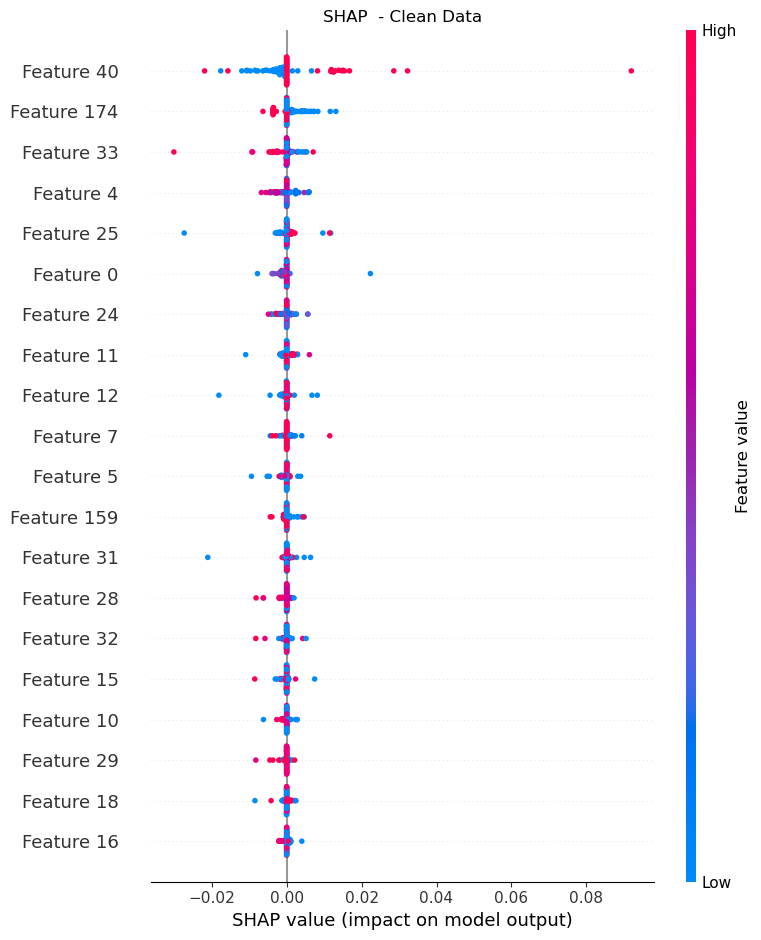

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure sample size is correctly applied to both SHAP values and the data
sample_size = X_test_sample.shape[0]  # Should be 100

# Recompute SHAP values for the clean dataset subset with the correct sample size
# Avoid any premature averaging or class selection
shap_values_clean = explainer.shap_values(X_test_sample)

# If shap_values_clean has an extra dimension, reduce it by averaging or selecting a class
if len(shap_values_clean.shape) == 3:
    # Option A: Average over classes
    shap_values_clean_mean = np.mean(shap_values_clean, axis=-1)  # Result: (sample_size, num_features)

    # Alternatively, Option B: Select a specific class if required (e.g., class 0)
    # shap_values_clean_mean = shap_values_clean[:, :, 0]

# Check the shapes for final confirmation
print("Adjusted Shape of SHAP values (shap_values_clean_mean):", shap_values_clean_mean.shape)
print("Shape of X_test_sample:", X_test_sample.shape)

# Plot the SHAP summary plot with adjusted shapes
plt.figure(figsize=(10, 6))
plt.title("SHAP  - Clean Data")
shap.summary_plot(shap_values_clean_mean, X_test_sample, plot_type="dot")



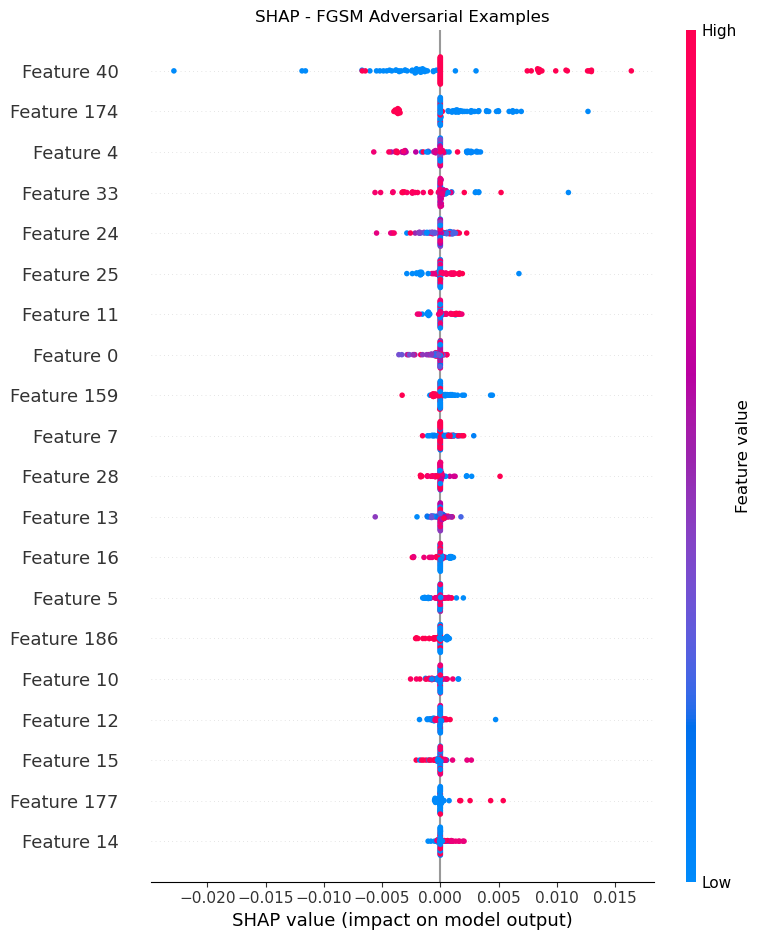

In [92]:
def adjust_shap_values(shap_values):
    # If SHAP values have a third dimension, average over it
    if len(shap_values.shape) == 3:
        shap_values = shap_values.mean(axis=-1)  # Average across classes if multi-class
    return shap_values
# 2. FGSM Adversarial Examples SHAP Summary Plot
shap_values_fgsm_mean = adjust_shap_values(np.array(shap_values_fgsm))

plt.figure(figsize=(10, 6))
plt.title("SHAP - FGSM Adversarial Examples")
shap.summary_plot(shap_values_fgsm_mean, X_test_fgsm_sample, plot_type="dot")


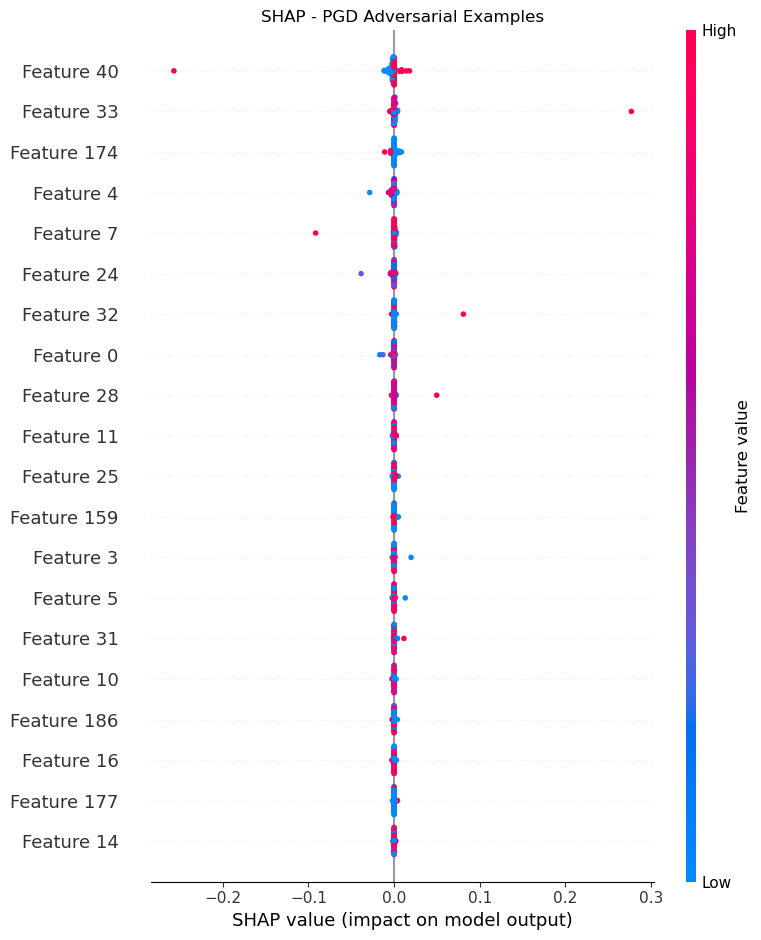

In [94]:
def adjust_shap_values(shap_values):
    # If SHAP values have a third dimension, average over it
    if len(shap_values.shape) == 3:
        shap_values = shap_values.mean(axis=-1)  # Average across classes if multi-class
    return shap_values

# 3. PGD Adversarial Examples SHAP Summary Plot
shap_values_pgd_mean = adjust_shap_values(np.array(shap_values_pgd))

plt.figure(figsize=(10, 6))
plt.title("SHAP - PGD Adversarial Examples")
shap.summary_plot(shap_values_pgd_mean, X_test_pgd_sample, plot_type="dot")

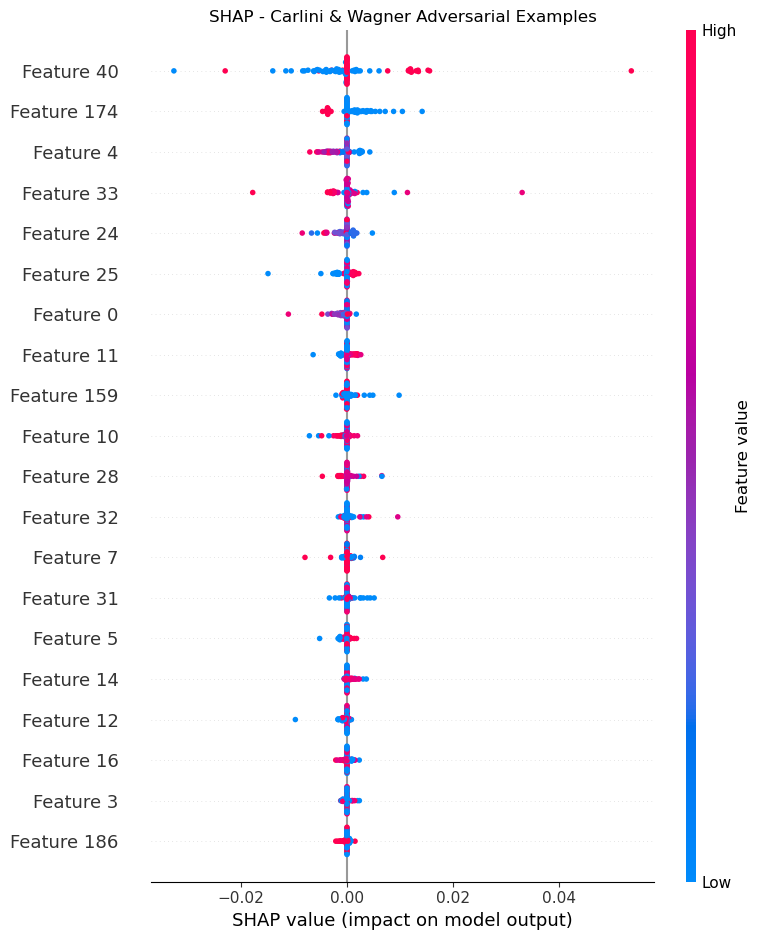

In [96]:
def adjust_shap_values(shap_values):
    # If SHAP values have a third dimension, average over it
    if len(shap_values.shape) == 3:
        shap_values = shap_values.mean(axis=-1)  # Average across classes if multi-class
    return shap_values
# 4. C&W Adversarial Examples SHAP Summary Plot
shap_values_cw_mean = adjust_shap_values(np.array(shap_values_cw))  # Average across classes

plt.figure(figsize=(10, 6))
plt.title("SHAP - Carlini & Wagner Adversarial Examples")
shap.summary_plot(shap_values_cw_mean, X_test_cw_sample, plot_type="dot")

In [26]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Verify the number of classes
num_classes = 10

print(f"Adjusted X_train_cnn shape: {X_train_cnn.shape}")
print(f"y_train shape: {y_train.shape}")
# Subsample X_train_cnn to match the length of y_train
X_train_cnn = X_train_cnn[:175341]


Adjusted X_train_cnn shape: (560000, 193, 1)
y_train shape: (175341,)


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Reshape data for 1D CNN input
X_train_cnn = X_train_resampled.reshape((X_train_resampled.shape[0], X_train_resampled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Define a 1D CNN model for tabular data
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer for 40 classes
])

X_train_cnn = X_train_cnn[:175341]
# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_cnn, y_test))


Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5480/5480 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.7926 - loss: 0.6380 - val_accuracy: 0.8532 - val_loss: 0.4111
Epoch 2/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.8389 - loss: 0.4688 - val_accuracy: 0.8547 - val_loss: 0.4000
Epoch 3/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.8431 - loss: 0.4479 - val_accuracy: 0.8618 - val_loss: 0.3846
Epoch 4/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.8445 - loss: 0.4403 - val_accuracy: 0.7971 - val_loss: 0.5605
Epoch 5/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.8449 - loss: 0.4340 - val_accuracy: 0.8695 - val_loss: 0.3847
Epoch 6/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.8461 - loss: 0.4305 - val_accuracy: 0.7861 - val_loss: 0.5545
Epoch 7/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.8485 - loss: 0.4241 - val_accuracy: 0.8140 - val_loss: 0.5258
Epoch 8/10
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.8474 - loss: 0.4254 - val

In [45]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred_cnn = cnn_model.predict(X_test_cnn).argmax(axis=1)
# Decode the predictions back to original labels
y_pred_decoded = label_encoder.inverse_transform(y_pred_cnn)
y_test_decoded = label_encoder.inverse_transform(y_test)
# Generate the classification report
cnn_class_report = classification_report(y_test_decoded, y_pred_decoded, zero_division=1)
print("Classification Report for CNN Model on Test Data:\n", cnn_class_report)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Classification Report for CNN Model on Test Data:
                 precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00       677
      Backdoor       1.00      0.00      0.00       583
           DoS       0.77      0.01      0.01      4089
      Exploits       0.57      0.91      0.70     11132
       Fuzzers       0.29      0.66      0.41      6062
       Generic       1.00      0.51      0.68     18871
        Normal       1.00      1.00      1.00     37000
Reconnaissance       0.69      0.75      0.72      3496
     Shellcode       0.57      0.03      0.06       378
         Worms       1.00      0.00      0.00        44

      accuracy                           0.77     82332
     macro avg       0.69      0.39      0.36     82332
  weighted avg       0.85      0.77      0.76     82332



In [51]:
import tensorflow as tf
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Convert the model to a TensorFlowV2Classifier
cnn_classifier = TensorFlowV2Classifier(
    model=cnn_model,
    nb_classes=num_classes,
    input_shape=(X_train_cnn.shape[1], 1),
    loss_object=tf.keras.losses.SparseCategoricalCrossentropy(),
    clip_values=(X_train_cnn.min(), X_train_cnn.max())
)

# Configure the FGSM attack
fgsm_attack = FastGradientMethod(estimator=cnn_classifier, eps=0.1)  # Adjust `eps` as needed

# Generate adversarial examples
X_test_fgsm = fgsm_attack.generate(x=X_test_cnn)


# Evaluate model performance on adversarial examples
y_pred_fgsm = cnn_classifier.predict(X_test_fgsm).argmax(axis=1)
fgsm_accuracy = accuracy_score(y_test, y_pred_fgsm)
fgsm_class_report = classification_report(y_test, y_pred_fgsm, zero_division=1)

# Decode the predicted labels for interpretability
y_pred_fgsm_labels = label_encoder.inverse_transform(y_pred_fgsm)
y_test_labels = label_encoder.inverse_transform(y_test)

# Calculate accuracy and generate the classification report
fgsm_accuracy = accuracy_score(y_test_labels, y_pred_fgsm_labels)
fgsm_class_report = classification_report(y_test_labels, y_pred_fgsm_labels, zero_division=1)
fgsm_conf_matrix = confusion_matrix(y_test_labels, y_pred_fgsm_labels)


print("CNN Model Accuracy on FGSM Adversarial Examples:", fgsm_accuracy)
print("\nClassification Report on FGSM Adversarial Examples:\n", fgsm_class_report)


CNN Model Accuracy on FGSM Adversarial Examples: 0.6776344556187145

Classification Report on FGSM Adversarial Examples:
                 precision    recall  f1-score   support

      Analysis       0.02      0.02      0.02       677
      Backdoor       1.00      0.00      0.00       583
           DoS       0.47      0.00      0.01      4089
      Exploits       0.53      0.70      0.60     11132
       Fuzzers       0.13      0.40      0.20      6062
       Generic       1.00      0.43      0.61     18871
        Normal       1.00      1.00      1.00     37000
Reconnaissance       0.12      0.09      0.11      3496
     Shellcode       0.36      0.01      0.02       378
         Worms       1.00      0.00      0.00        44

      accuracy                           0.68     82332
     macro avg       0.56      0.27      0.26     82332
  weighted avg       0.80      0.68      0.69     82332



In [54]:
from art.attacks.evasion import ProjectedGradientDescent

# Configure PGD attack parameters
epsilon = 0.1         # Maximum perturbation
eps_step = 0.01       # Step size per iteration
max_iter = 40         # Number of iterations

# Create the PGD attack
pgd_attack = ProjectedGradientDescent(
    estimator=cnn_classifier, 
    eps=epsilon, 
    eps_step=eps_step, 
    max_iter=max_iter
)

# Generate adversarial examples on the test set
X_test_pgd = pgd_attack.generate(x=X_test_scaled)

PGD - Batches: 0it [00:00, ?it/s]

2024-11-06 20:50:36.399038: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [76]:
print(f"Shape of X_test_pgd: {X_test_pgd.shape}")
X_test_pgd = X_test_pgd.reshape(-1, 193, 1)


Shape of X_test_pgd: (82332, 193)


In [80]:
# Predict on the PGD adversarial examples
y_pred_pgd = cnn_model.predict(X_test_pgd).argmax(axis=1)

# Decode the predicted labels for interpretability
y_pred_pgd_labels = label_encoder.inverse_transform(y_pred_pgd)
y_test_labels = label_encoder.inverse_transform(y_test)

# Calculate accuracy and generate the classification report
pgd_accuracy = accuracy_score(y_test_labels, y_pred_pgd_labels)
pgd_class_report = classification_report(y_test_labels, y_pred_pgd_labels, zero_division=1)
pgd_conf_matrix = confusion_matrix(y_test_labels, y_pred_pgd_labels)

print("CNN Model Accuracy on PGD Adversarial Examples:", pgd_accuracy)
print("\nClassification Report on PGD Adversarial Examples:\n", pgd_class_report)

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
CNN Model Accuracy on PGD Adversarial Examples: 0.6554681047466355

Classification Report on PGD Adversarial Examples:
                 precision    recall  f1-score   support

      Analysis       0.03      0.27      0.06       677
      Backdoor       1.00      0.00      0.00       583
           DoS       0.45      0.02      0.03      4089
      Exploits       0.49      0.52      0.51     11132
       Fuzzers       0.11      0.27      0.16      6062
       Generic       1.00      0.47      0.64     18871
        Normal       1.00      1.00      1.00     37000
Reconnaissance       0.09      0.10      0.10      3496
     Shellcode       0.13      0.01      0.01       378
         Worms       1.00      0.00      0.00        44

      accuracy                           0.66     82332
     macro avg       0.53      0.27      0.25     82332
  weighted avg       0.79      0.66      0.68     82332



In [84]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Select a random sample (e.g., 10%) of the test data
sample_size = int(0.1 * len(X_test_scaled))  # Adjust to fit your available test data
indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)

# Create the smaller subset
X_test_small = X_test_scaled[indices]
y_test_small = y_test[indices]

In [96]:
from art.attacks.evasion import CarliniL2Method

# Configure the Carlini & Wagner attack
cw_attack = CarliniL2Method(
    classifier=cnn_classifier,
    confidence=0.1,   # Set desired confidence level
    max_iter=10,      # Number of optimization iterations; increase for stronger attacks
    batch_size=32     # Batch size for processing
)

# Generate adversarial examples on the smaller subset
X_test_cw = cw_attack.generate(x=X_test_small[:200])

C&W L_2:   0%|          | 0/7 [00:00<?, ?it/s]

In [100]:
print(f"Shape of X_test_cw: {X_test_cw.shape}")


Shape of X_test_cw: (200, 193)


In [105]:
# Predict on the C&W adversarial examples
# Reshape X_test_cw to add the channel dimension
X_test_cw = X_test_cw.reshape(-1, 193, 1)
# Use the first 200 labels to match the subset used for adversarial examples



y_pred_cw = cnn_model.predict(X_test_cw).argmax(axis=1)

# Decode the predicted and true labels for interpretability
y_pred_cw_labels = label_encoder.inverse_transform(y_pred_cw)
y_test_small_labels = label_encoder.inverse_transform(y_test_small)
y_test_small_labels = y_test_small_labels[:200]
# Calculate accuracy and generate the classification report
cw_accuracy = accuracy_score(y_test_small_labels, y_pred_cw_labels)
cw_class_report = classification_report(y_test_small_labels, y_pred_cw_labels, zero_division=1)
cw_conf_matrix = confusion_matrix(y_test_small_labels, y_pred_cw_labels)

print("CNN Model Accuracy on Carlini & Wagner Adversarial Examples:", cw_accuracy)
print("\nClassification Report on Carlini & Wagner Adversarial Examples:\n", cw_class_report)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
CNN Model Accuracy on Carlini & Wagner Adversarial Examples: 0.73

Classification Report on Carlini & Wagner Adversarial Examples:
                 precision    recall  f1-score   support

      Analysis       0.08      0.33      0.12         3
           DoS       1.00      0.00      0.00         8
      Exploits       0.52      0.44      0.48        27
       Fuzzers       0.07      0.20      0.11        10
       Generic       1.00      0.69      0.81        48
        Normal       1.00      1.00      1.00        98
Reconnaissance       0.00      0.00      0.00         5
     Shellcode       0.00      0.00      0.00         1

      accuracy                           0.73       200
     macro avg       0.46      0.33      0.32       200
  weighted avg       0.85      0.73      0.76       200



In [128]:
import numpy as np
import shap
# Check and print the shape of the CNN model input
print("Expected CNN Model Input Shape:", cnn_model.input_shape)

# Step 1: Prepare and check background data shape
background_data_cnn = X_train_resampled[np.random.choice(X_train_resampled.shape[0], 100, replace=False)]
print("Original Background Data Shape:", background_data_cnn.shape)

# Ensure background_data_cnn has the shape (sample_size, 28, 1)
if background_data_cnn.shape[1:] != (193, 1):
    background_data_cnn = background_data_cnn.reshape(-1,193, 1)

explainer_cnn = shap.DeepExplainer(cnn_model, background_data_cnn)

print("Reshaped Background Data Shape:", background_data_cnn.shape)

# Step 2: Define sample size and generate separate sample indices for each dataset
sample_size = 100
sample_indices_cnn = np.random.choice(X_test_cnn.shape[0], sample_size, replace=False)
sample_indices_fgsm = np.random.choice(X_test_fgsm.shape[0], sample_size, replace=False)
sample_indices_pgd = np.random.choice(X_test_pgd.shape[0], sample_size, replace=False)
sample_indices_cw = np.random.choice(X_test_cw.shape[0], sample_size, replace=False)

# Subset and reshape each dataset, and print out the shape of each
X_test_cnn_sample = X_test_cnn[sample_indices_cnn]
X_test_fgsm_sample = X_test_fgsm[sample_indices_fgsm]
X_test_pgd_sample = X_test_pgd[sample_indices_pgd]
X_test_cw_sample = X_test_cw[sample_indices_cw]

print("Original X_test_cnn_sample Shape:", X_test_cnn_sample.shape)
print("Original X_test_fgsm_sample Shape:", X_test_fgsm_sample.shape)
print("Original X_test_pgd_sample Shape:", X_test_pgd_sample.shape)
print("Original X_test_cw_sample Shape:", X_test_cw_sample.shape)

# Ensure each test dataset sample has shape (sample_size, 28, 1)
if X_test_cnn_sample.shape[1:] != (193, 1):
    X_test_cnn_sample = X_test_cnn_sample.reshape(-1, 193, 1)
if X_test_fgsm_sample.shape[1:] != (193, 1):
    X_test_fgsm_sample = X_test_fgsm_sample.reshape(-1,193, 1)
if X_test_pgd_sample.shape[1:] != (193, 1):
    X_test_pgd_sample = X_test_pgd_sample.reshape(-1, 193, 1)
if X_test_cw_sample.shape[1:] != (193, 1):
    X_test_cw_sample = X_test_cw_sample.reshape(-1, 193, 1)

# Print the shapes again after reshaping
print("Reshaped X_test_cnn_sample Shape:", X_test_cnn_sample.shape)
print("Reshaped X_test_fgsm_sample Shape:", X_test_fgsm_sample.shape)
print("Reshaped X_test_pgd_sample Shape:", X_test_pgd_sample.shape)
print("Reshaped X_test_cw_sample Shape:", X_test_cw_sample.shape)

shap_values_clean_cnn = explainer_cnn.shap_values(X_test_cnn_sample)
shap_values_fgsm_cnn = explainer_cnn.shap_values(X_test_fgsm_sample)
shap_values_pgd_cnn = explainer_cnn.shap_values(X_test_pgd_sample)
shap_values_cw_cnn = explainer_cnn.shap_values(X_test_cw_sample)


Expected CNN Model Input Shape: (None, 193, 1)
Original Background Data Shape: (100, 193)
Reshaped Background Data Shape: (100, 193, 1)
Original X_test_cnn_sample Shape: (100, 193, 1)
Original X_test_fgsm_sample Shape: (100, 193, 1)
Original X_test_pgd_sample Shape: (100, 193, 1)
Original X_test_cw_sample Shape: (100, 193, 1)
Reshaped X_test_cnn_sample Shape: (100, 193, 1)
Reshaped X_test_fgsm_sample Shape: (100, 193, 1)
Reshaped X_test_pgd_sample Shape: (100, 193, 1)
Reshaped X_test_cw_sample Shape: (100, 193, 1)


/opt/anaconda3/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_55. Received: the structure of inputs=['*']
  warnings.warn(


In [151]:
import numpy as np
import matplotlib.pyplot as plt

# Define sample size and number of features
sample_size = 40
num_features = 193

# Ensure each dataset subset has the correct sample size
X_test_cnn_sample = X_test_cnn_sample[:sample_size]
X_test_fgsm_sample = X_test_fgsm_sample[:sample_size]
X_test_pgd_sample = X_test_pgd_sample[:sample_size]
X_test_cw_sample = X_test_cw_sample[:sample_size]

# Generate SHAP values for each subset with correct sample size
shap_values_clean_cnn = explainer_cnn.shap_values(X_test_cnn_sample)[0]
shap_values_fgsm_cnn = explainer_cnn.shap_values(X_test_fgsm_sample)[0]
shap_values_pgd_cnn = explainer_cnn.shap_values(X_test_pgd_sample)[0]
shap_values_cw_cnn = explainer_cnn.shap_values(X_test_cw_sample)[0]

# Check shapes to verify that SHAP values have been computed across all samples
def verify_shap_values(shap_values, sample_size, num_features):
    # If SHAP values have an extra class dimension, average over it
    if len(shap_values.shape) == 3:
        shap_values = shap_values.mean(axis=-1)  # Average across classes
    # Ensure the correct shape by reshaping
    if shap_values.shape[0] != sample_size:
        shap_values = np.tile(shap_values, (sample_size, 1))  # Repeat if only 1 sample was used
    shap_values = shap_values.reshape(sample_size, num_features)
    return shap_values

# Apply the verification function to each SHAP value matrix
shap_values_clean_cnn = verify_shap_values(shap_values_clean_cnn, sample_size, num_features)
shap_values_fgsm_cnn = verify_shap_values(shap_values_fgsm_cnn, sample_size, num_features)
shap_values_pgd_cnn = verify_shap_values(shap_values_pgd_cnn, sample_size, num_features)
shap_values_cw_cnn = verify_shap_values(shap_values_cw_cnn, sample_size, num_features)

# Reshape each dataset to match (sample_size, num_features)
X_test_cnn_sample_reduced = X_test_cnn_sample.reshape(sample_size, num_features)
X_test_fgsm_sample_reduced = X_test_fgsm_sample.reshape(sample_size, num_features)
X_test_pgd_sample_reduced = X_test_pgd_sample.reshape(sample_size, num_features)
X_test_cw_sample_reduced = X_test_cw_sample.reshape(sample_size, num_features)

# Verify shapes before plotting
print("Adjusted Shape of SHAP values for clean data:", shap_values_clean_cnn.shape)
print("Shape of X_test_cnn_sample_reduced:", X_test_cnn_sample_reduced.shape)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_55. Received: the structure of inputs=['*']
  warnings.warn(


Adjusted Shape of SHAP values for clean data: (40, 193)
Shape of X_test_cnn_sample_reduced: (40, 193)


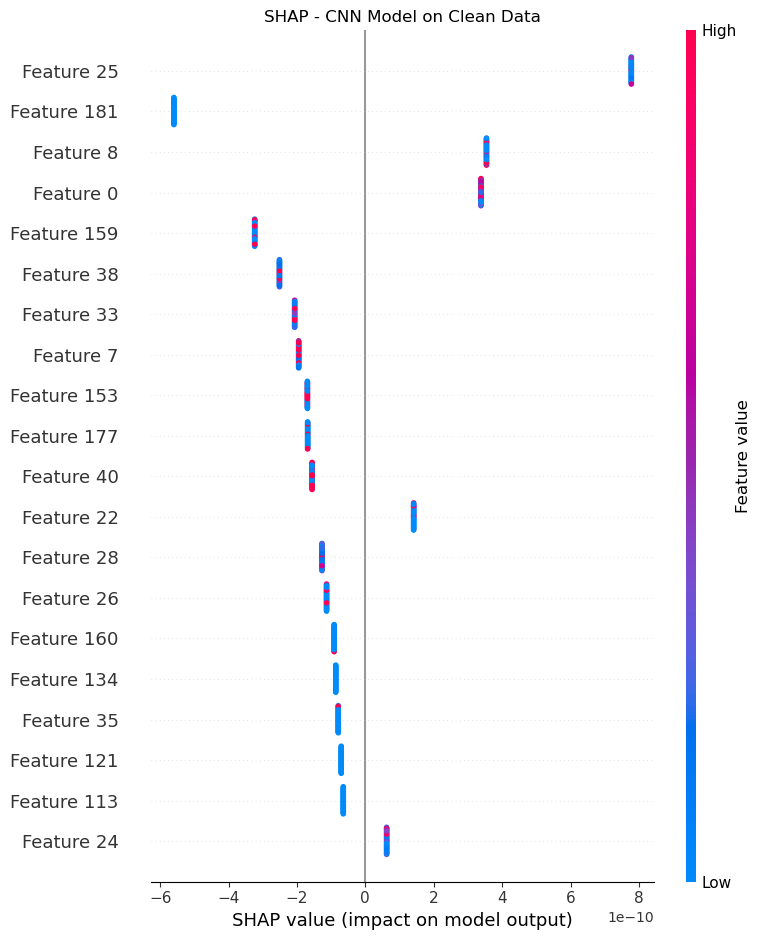

In [153]:
import matplotlib.pyplot as plt
# Plot SHAP Beeswarm Plots
plt.figure(figsize=(10, 6))
plt.title("SHAP - CNN Model on Clean Data")
shap.summary_plot(shap_values_clean_cnn, X_test_cnn_sample_reduced, plot_type="dot")

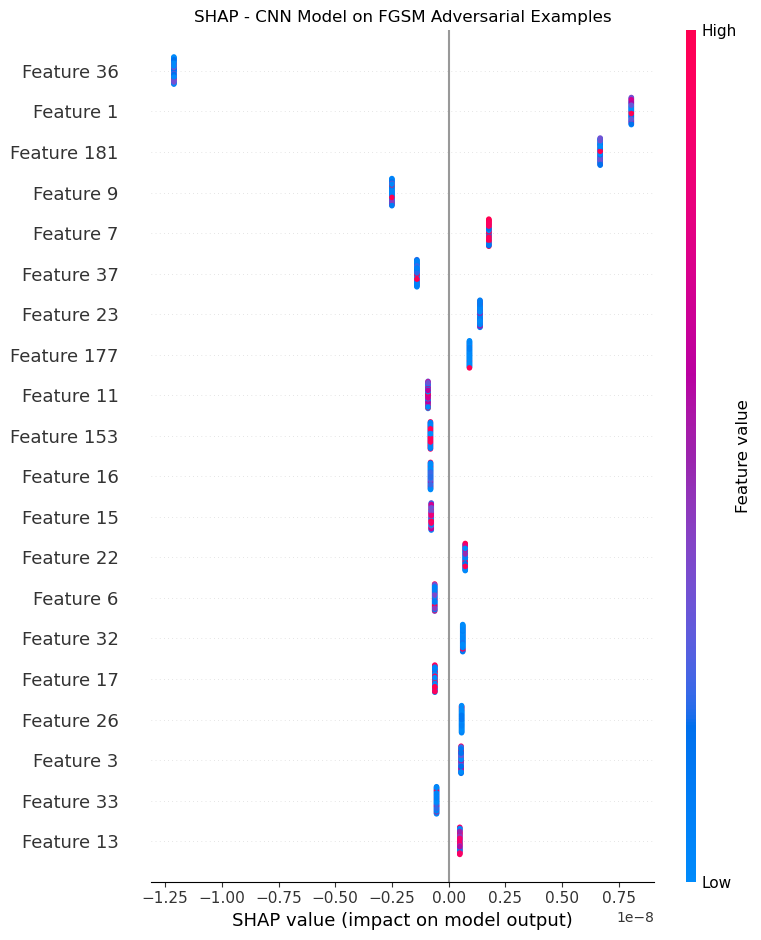

In [155]:
plt.figure(figsize=(10, 6))
plt.title("SHAP - CNN Model on FGSM Adversarial Examples")
shap.summary_plot(shap_values_fgsm_cnn, X_test_fgsm_sample_reduced, plot_type="dot")


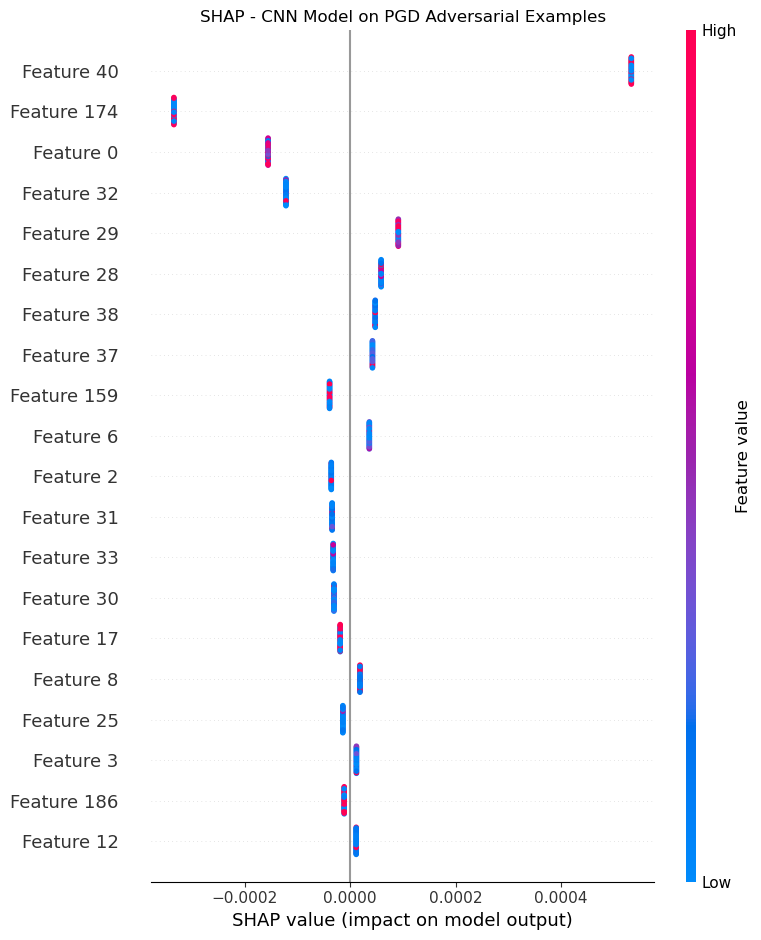

In [157]:
plt.figure(figsize=(10, 6))
plt.title("SHAP - CNN Model on PGD Adversarial Examples")
shap.summary_plot(shap_values_pgd_cnn, X_test_pgd_sample_reduced, plot_type="dot")

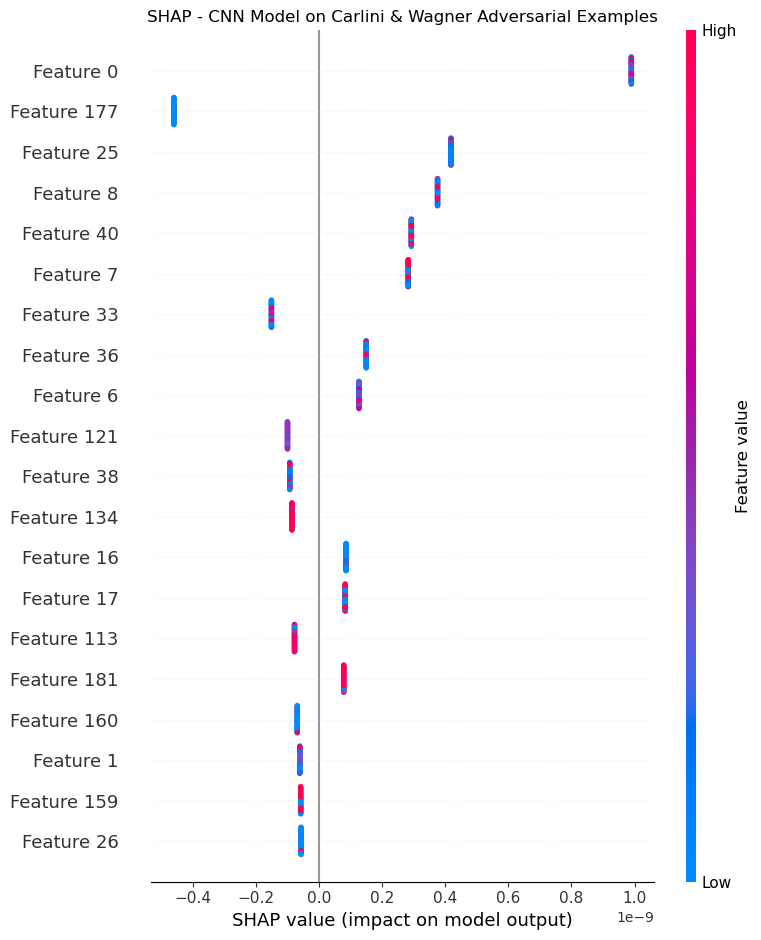

In [159]:

plt.figure(figsize=(10, 6))
plt.title("SHAP - CNN Model on Carlini & Wagner Adversarial Examples")
shap.summary_plot(shap_values_cw_cnn, X_test_cw_sample_reduced, plot_type="dot")